In [14]:
!pip install statsmodels --upgrade

In [15]:
import pandas as pd
import numpy as np
import json
import os
import statsmodels
from scipy.stats import shapiro

In [16]:
# Mount google drive
from google.colab import drive
import gc

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd ./drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER/

[Errno 2] No such file or directory: './drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER/'
/content/drive/My Drive/SUNY_Poly_DSA598/datasets/FEVER


In [18]:
!ls -a

AVeriTeC			 fever-scorer	    paper_test.jsonl
.DS_Store			 fever-train.jsonl  tabular_sets
fever2-adversarial.jsonl	 GPT_sets	    wiki-pages
feverous_train_challenges.jsonl  paper_dev.jsonl


In [19]:
def load_jsonl(file_path, encoding='utf-8'):
    """Loads a JSON Lines file into a list of Python objects."""
    data = []
    with open(file_path, 'r', encoding=encoding) as f:  # Specify encoding for safety
        for line in f:
            data.append(json.loads(line))  # Parse each line individually
    return data

In [20]:
# Data paths (replace with your actual paths if different)
fever_path = "./datasets/FEVER/"
train_clf_path = f"tabular_sets/tabular_clf_paper_dev_train/v1_segmented_sentIDs_n3461_04-04_002.csv"
valid_clf_path = f"tabular_sets/tabular_clf_paper_dev_valid/v1_segmented_sentIDs_n1482_04-04_002.csv"
train_sentEx_path = f"tabular_sets/tabular_sentEx_paper_dev_train/v1_segmented_sentIDs_n3461_04-04_002.csv"
valid_sentEx_path = f"tabular_sets/tabular_sentEx_paper_dev_valid/v1_segmented_sentIDs_n1482_04-04_002.csv"
test_path = f"paper_test.jsonl"
train_path = f"paper_dev.jsonl"

# Load datasets
train_clf = pd.read_csv(train_clf_path)
valid_clf = pd.read_csv(valid_clf_path)
train_sentEx = pd.read_csv(train_sentEx_path)
valid_sentEx = pd.read_csv(valid_sentEx_path)
test_jsonl = load_jsonl(test_path)
train_jsonl = load_jsonl(train_path)

In [21]:
# Show the distribution of labels
print(f"SentEx train set label distribution:")
print(train_sentEx['label'].value_counts())
print(f"SentEx valid set label distribution:")
print(valid_sentEx['label'].value_counts())
print(f"CLF train set label distribution:")
print(train_clf['label'].value_counts())
print(f"CLF valid set label distribution:")
print(valid_clf['label'].value_counts())


# Balance the labels by reducing each to the minimum count
min_count = min(train_sentEx['label'].value_counts())
train_sentEx = train_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(valid_sentEx['label'].value_counts())
valid_sentEx = valid_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(train_clf['label'].value_counts())
train_clf = train_clf.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
min_count = min(valid_clf['label'].value_counts())
valid_clf = valid_clf.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

# Show the distribution of labels after balancing
print(f"SentEx train set label distribution after balancing:")
print(train_sentEx['label'].value_counts())
print(f"SentEx valid set label distribution after balancing:")
print(valid_sentEx['label'].value_counts())
print(f"CLF train set label distribution after balancing:")
print(train_clf['label'].value_counts())
print(f"CLF valid set label distribution after balancing:")
print(valid_clf['label'].value_counts())

SentEx train set label distribution:
label
SUPPORTS           1156
REFUTES            1156
NOT ENOUGH INFO    1149
Name: count, dtype: int64
SentEx valid set label distribution:
label
SUPPORTS           495
REFUTES            495
NOT ENOUGH INFO    488
Name: count, dtype: int64
CLF train set label distribution:
label
SUPPORTS           1156
REFUTES            1156
NOT ENOUGH INFO    1149
Name: count, dtype: int64
CLF valid set label distribution:
label
SUPPORTS           496
REFUTES            496
NOT ENOUGH INFO    486
Name: count, dtype: int64
SentEx train set label distribution after balancing:
label
NOT ENOUGH INFO    1149
REFUTES            1149
SUPPORTS           1149
Name: count, dtype: int64
SentEx valid set label distribution after balancing:
label
NOT ENOUGH INFO    488
REFUTES            488
SUPPORTS           488
Name: count, dtype: int64
CLF train set label distribution after balancing:
label
NOT ENOUGH INFO    1149
REFUTES            1149
SUPPORTS           1149
Name: cou

<ipython-input-21-35adf38b2920>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sentEx = train_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
<ipython-input-21-35adf38b2920>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_sentEx = valid_sentEx.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
<ipython-input-21-35adf38b2920>:18: 

In [22]:
print(train_sentEx.info())
print(valid_sentEx.info())
print(train_clf.info())
print(valid_clf.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3447 non-null   int64  
 1   claim                 3447 non-null   object 
 2   evidence_sentences    3447 non-null   object 
 3   full_text             3447 non-null   object 
 4   label                 3447 non-null   object 
 5   syntactic_complexity  3447 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 161.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1464 non-null   int64  
 1   claim                 1464 non-null   object 
 2   evidence_sentences    1464 non-null   object 
 3   full_text             1464 non-null   object 
 4   

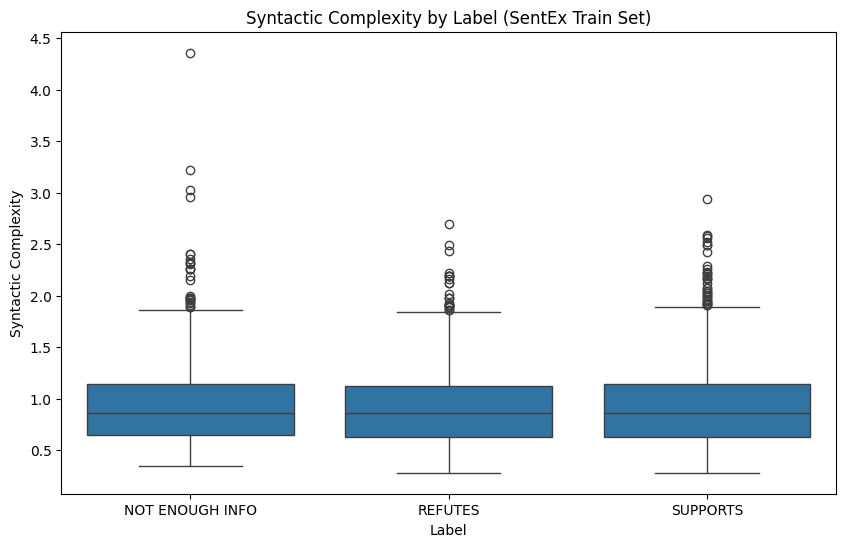

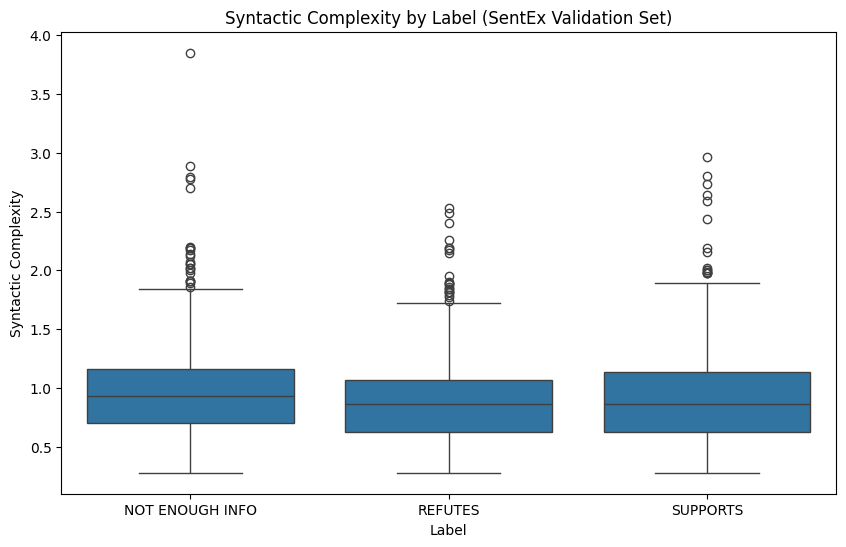

Shapiro Test Results for SentEx Train Set:
Shapiro stat = 0.9267116183610508, p-value = 4.070077098602189e-38
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for SentEx Validation Set:
Shapiro stat = 0.9097218247902594, p-value = 1.2885706089527766e-28
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Train Set:
Shapiro stat = 0.932450942976018, p-value = 6.1277238770993105e-37
Sample does not look Gaussian (reject H0)
--------------------------------------------

Shapiro Test Results for CLF Validation Set:
Shapiro stat = 0.9219004584421788, p-value = 7.826466358584343e-27
Sample does not look Gaussian (reject H0)
--------------------------------------------

Levene Test Results for SentEx Train Set:
Levene stat = 0.3664515547208416, p-value = 0.6932167426416789
Homogeneity of variance (fail to reject H0)
--------------------------------------------

Levene T

In [23]:
# plot the syntactic_complexity by label
import matplotlib.pyplot as plt
import seaborn as sns

def plot_syntactic_complexity(data, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y='syntactic_complexity', data=data)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Syntactic Complexity')
    plt.show()

plot_syntactic_complexity(train_sentEx, 'Syntactic Complexity by Label (SentEx Train Set)')
plot_syntactic_complexity(valid_sentEx, 'Syntactic Complexity by Label (SentEx Validation Set)')

# Check for normality using Shapiro-Wilk test
def check_normality(data, column, title):
    stat, p = shapiro(data[column])
    print('Shapiro Test Results for ' + title + ':')
    print(f'Shapiro stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print("--------------------------------------------\n")
check_normality(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
check_normality(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
check_normality(train_clf, 'syntactic_complexity', 'CLF Train Set')
check_normality(valid_clf, 'syntactic_complexity', 'CLF Validation Set')

# Check for homogeneity of variance using Levene's test
from scipy.stats import levene
def check_homogeneity(data, column, title):
    groups = data.groupby('label')[column].apply(list)
    stat, p = levene(*groups)
    print('Levene Test Results for ' + title + ':')
    print(f'Levene stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Homogeneity of variance (fail to reject H0)')
    else:
        print('Not homogenous (reject H0)')
    print("--------------------------------------------\n")
check_homogeneity(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
check_homogeneity(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
check_homogeneity(train_clf, 'syntactic_complexity', 'CLF Train Set')
check_homogeneity(valid_clf, 'syntactic_complexity', 'CLF Validation Set')


In [24]:
import statsmodels.formula.api as smf # import the formula API from statsmodels

# Ordinal encode the label column
train_sentEx['label'] = train_sentEx['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
valid_sentEx['label'] = valid_sentEx['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
train_clf['label'] = train_clf['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})
valid_clf['label'] = valid_clf['label'].map({'SUPPORTS': 1, 'REFUTES': 0, 'NOT ENOUGH INFO': 2})


# Perform an ANOVA on label and syntactic_complexity using statsmodels
model = smf.ols('label ~ syntactic_complexity', data=train_sentEx).fit() #refer to formula API using the alias smf
print(model.summary())
print("--------------------------------------------\n")

# Perform a Kruskal-Wallis test
from scipy.stats import kruskal

def kruskal_test(data, column, title):
    groups = data.groupby('label')[column].apply(list)
    stat, p = kruskal(*groups)
    print('Kruskal-Wallis Test Results for ' + title + ':')
    print(f'Kruskal stat = {stat}, p-value = {p}')
    alpha = 0.05
    if p > alpha:
        print('Median ranks are equal (fail to reject H0)')
    else:
        print('Median ranks are not equal (reject H0)')
    print("--------------------------------------------\n")
kruskal_test(train_sentEx, 'syntactic_complexity', 'SentEx Train Set')
kruskal_test(valid_sentEx, 'syntactic_complexity', 'SentEx Validation Set')
kruskal_test(train_clf, 'syntactic_complexity', 'CLF Train Set')
kruskal_test(valid_clf, 'syntactic_complexity', 'CLF Validation Set')


                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.201
Date:                Sat, 12 Apr 2025   Prob (F-statistic):             0.0405
Time:                        05:56:18   Log-Likelihood:                -4190.2
No. Observations:                3447   AIC:                             8384.
Df Residuals:                    3445   BIC:                             8397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9342 

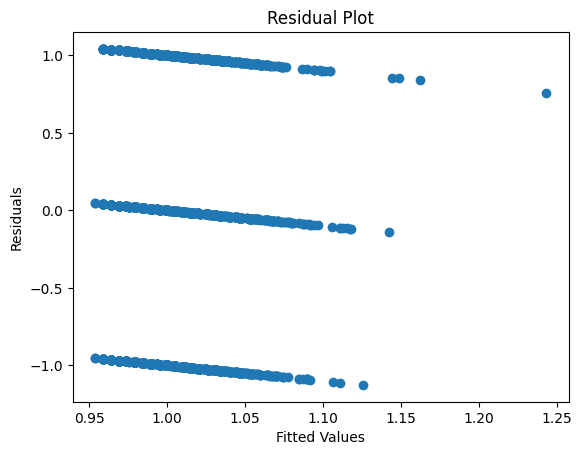

In [25]:
# Plot residuals from the model
import matplotlib.pyplot as plt

plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Parse tree depth

In [ ]:
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

def calculate_parse_tree_depth(sentence):
    """
    Calculate the depth of the dependency parse tree for a given sentence.
    """
    doc = nlp(sentence)
    def get_depth(token):
        if not list(token.children):  # If the token has no children, depth is 1
            return 1
        return 1 + max(get_depth(child) for child in token.children)
    
    # Get the depth of the root token
    return max(get_depth(sent.root) for sent in doc.sents)

# Example usage
sentence = "The quick brown fox jumps over the lazy dog."
depth = calculate_parse_tree_depth(sentence)
print(f"Parse tree depth: {depth}")